# Dog Breeding Classifications

![](https://thehappypuppysite.com/wp-content/uploads/2017/07/lab.jpg)

# 1. Import 


In [1]:
# System
import sys
import os
import argparse

# Time
import time
import datetime

# Numerical Data
import random
import numpy as np 
import pandas as pd

# Tools
import shutil
from glob import glob
from tqdm import tqdm
import gc

# NLP
import re

# Preprocessing
from sklearn import preprocessing
from sklearn.utils import class_weight as cw
from sklearn.utils import shuffle

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Machine Learning Models
from sklearn import svm
from sklearn.svm import LinearSVC, SVC

# Evaluation Metrics
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score


# Deep Learning - Keras -  Preprocessing
from keras.preprocessing.image import ImageDataGenerator

# Deep Learning - Keras - Model
import keras
from keras import models
from keras.models import Model
from keras.models import Sequential

# Deep Learning - Keras - Layers
from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, Embedding, \
    Conv2D, SeparableConv1D, Add, BatchNormalization, Activation, GlobalAveragePooling2D, LeakyReLU, Flatten
from keras.layers import Dense, Input, Dropout, MaxPool2D, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
from keras.layers.pooling import _GlobalPooling1D

from keras.regularizers import l2

# Deep Learning - Keras - Pretrained Models
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet201
from keras.applications.nasnet import NASNetMobile, NASNetLarge

from keras.applications.nasnet import preprocess_input

# Deep Learning - Keras - Model Parameters and Evaluation Metrics
from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop
from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy

# Deep Learning - Keras - Visualisation
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, LearningRateScheduler
# from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

# Deep Learning - TensorFlow
import tensorflow as tf

# Graph/ Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

# Image
import cv2
from PIL import Image
from IPython.display import display

# np.random.seed(42)

%matplotlib inline

# Input data
print(os.listdir("../input/"))

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

['dog-breed-identification']


# 2. Functions

In [2]:
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()  

# 3. Input Configuration

In [3]:
input_directory = r"../input/dog-breed-identification/"
output_directory = r"../output/"

training_dir = input_directory + "train"
testing_dir = input_directory + "test"

if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
figure_directory = "../output/figures"
if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)    
    
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

In [4]:
train_df = pd.read_csv(input_directory + "/labels.csv")
train_df.rename(columns={"breed": "label"}, inplace=True)
train_df["id"] = train_df["id"].apply(lambda x: x+"."+"jpg")
train_df.head()

id             label
0  000bec180eb18c7604dcecc8fe0dba07.jpg       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97.jpg             dingo
2  001cdf01b096e06d78e9e5112d419397.jpg          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d.jpg          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62.jpg  golden_retriever

In [5]:
classes = list(train_df["label"].unique())
classes.sort()

In [6]:
test_files = os.listdir(testing_dir)
    
test_df = pd.DataFrame({"id": test_files, "label": "boston_bull"})

test_df.head()

id        label
0  266d72317675f3fafaf614cd80c04182.jpg  boston_bull
1  328b72aeafcb0ea19df3f4198f351d66.jpg  boston_bull
2  d970085b1f181e52ff8046fe028ead6a.jpg  boston_bull
3  fcf30274c748e760029514f152c8419d.jpg  boston_bull
4  6705e29c64d4949dfa72e0cb9e3bb950.jpg  boston_bull

In [7]:
len(train_df), len(test_df)

(10222, 10358)

# 4. Visualization

In [8]:
def plot_image(file, directory=None, sub=False, aspect=None, title=False):
    path = directory + "/" + file
    
    img = plt.imread(path)
    
    plt.imshow(img, aspect=aspect)
    if title:
        plt.title(file)
    plt.xticks([])
    plt.yticks([])
    
    if sub:
        plt.show()
        
def plot_img_dir(directory=training_dir, count=5):
    selected_files = random.sample(os.listdir(directory), count)
    
    ncols = 5
    nrows = count//ncols if count%ncols==0 else count//ncols+1
    
    figsize=(20, ncols*nrows)

    ticksize = 14
    titlesize = ticksize + 8
    labelsize = ticksize + 5


    params = {'figure.figsize' : figsize,
              'axes.labelsize' : labelsize,
              'axes.titlesize' : titlesize,
              'xtick.labelsize': ticksize,
              'ytick.labelsize': ticksize}

    plt.rcParams.update(params)
    
    i=0
    
    for file in selected_files:        
        plt.subplot(nrows, ncols, i+1)
        path = directory + file
        plot_image(file, directory, aspect=None)

        i=i+1
    
    plt.tight_layout()
    plt.show()
    
def plot_img_df(directory=None, df=None, filename="id", label = "label", count=5, num_cat=-1):
    label_map = {}
    
    classes = list(set(df[label]))
#     classes.sort()
    
    for l in classes:
        label_map[l] = df[df[label]==l][filename]
        label_map[l] = label_map[l].sample(count, replace=True)
        
    
    
    ncols = 5
    nrows = count//ncols if count%ncols==0 else count//ncols+1
#     print(nrows, ncols)
    
    figsize=(20, ncols*nrows)

    ticksize = 14
    titlesize = ticksize + 8
    labelsize = ticksize + 5


    params = {'figure.figsize' : figsize,
              'axes.labelsize' : labelsize,
              'axes.titlesize' : titlesize,
              'xtick.labelsize': ticksize,
              'ytick.labelsize': ticksize}

    plt.rcParams.update(params)
    
    i=0
    if num_cat==-1:
        print("Showing {} classes...".format(len(label_map)))
    else:
        print("Showing {} classes...".format(num_cat))
        
    for label in label_map:
        if num_cat==i:
            break
        label2 = re.sub("_", " ", label)
        label2 = label2.title()
        print(str(i+1) + ". " + label2)
        
        j=0
        for id, file in label_map[label].iteritems():
            plt.subplot(nrows, 5, j+1)
            plot_image(file, directory, aspect='auto')
            j=j+1
            
        plt.tight_layout()
        plt.show()
        
        
        i+=1
        
def plot_img_dir_main(directory=training_dir, count=5):
    labels = os.listdir(directory)
    
    for label in labels:
        label2 = re.sub("_", " ", label)
        label2 = label2.title()
        print(label2)
        plot_img_dir(directory=directory+"/"+label, count=count)
        num_cat-=1
        

## 4.1 Show image samples of all classes/ selected number of classes

Showing 5 classes...
1. Curly-Coated Retriever


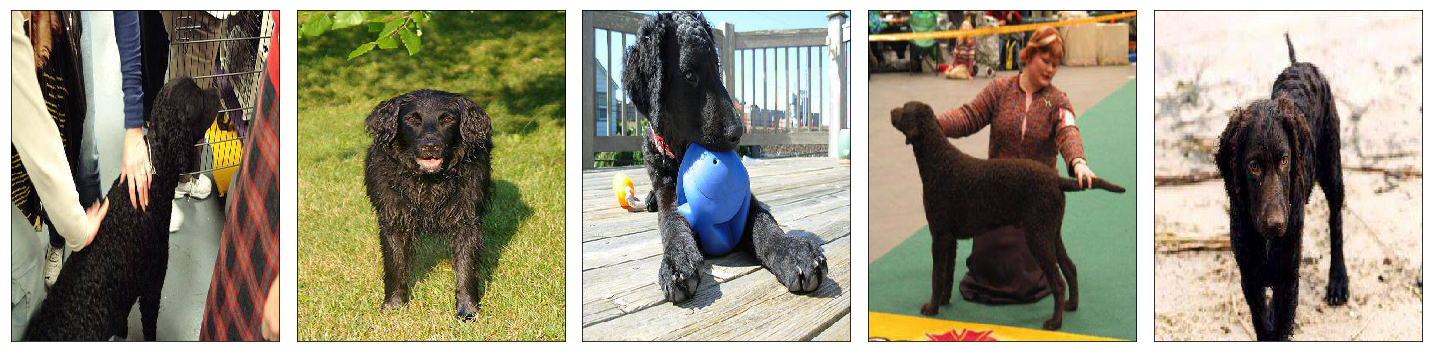

2. Sealyham Terrier


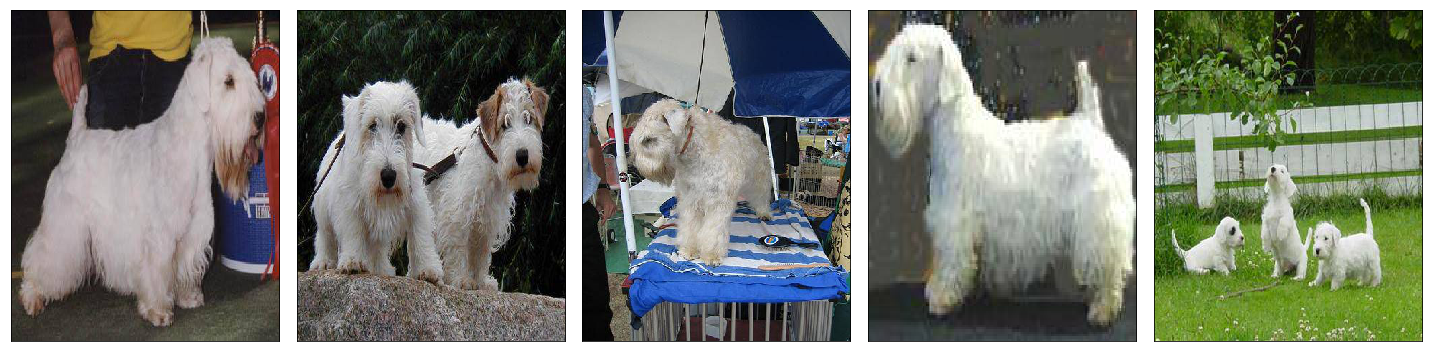

3. Tibetan Terrier


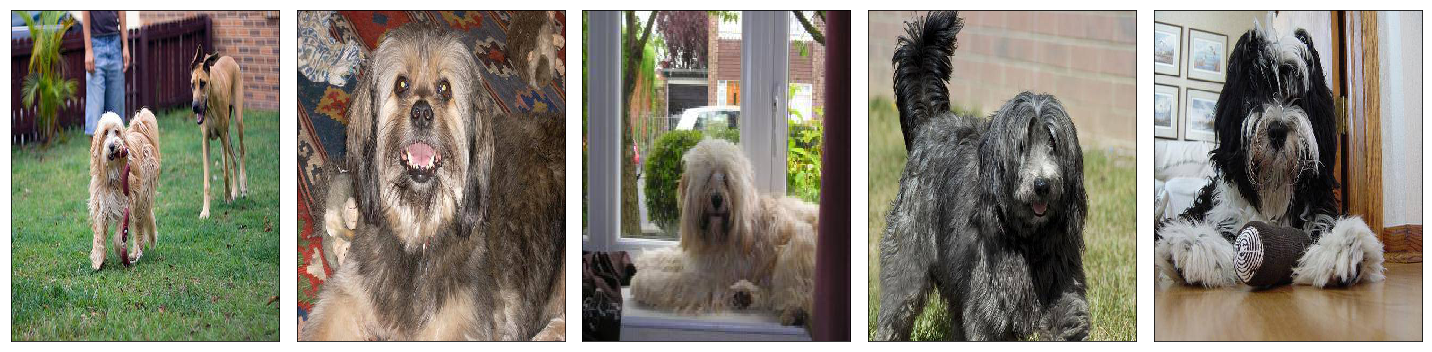

4. Border Terrier


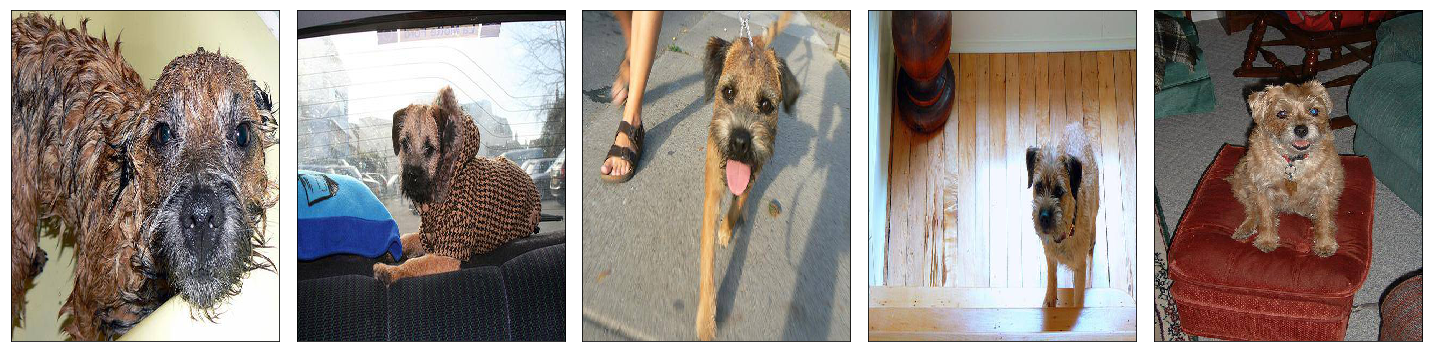

5. Chihuahua


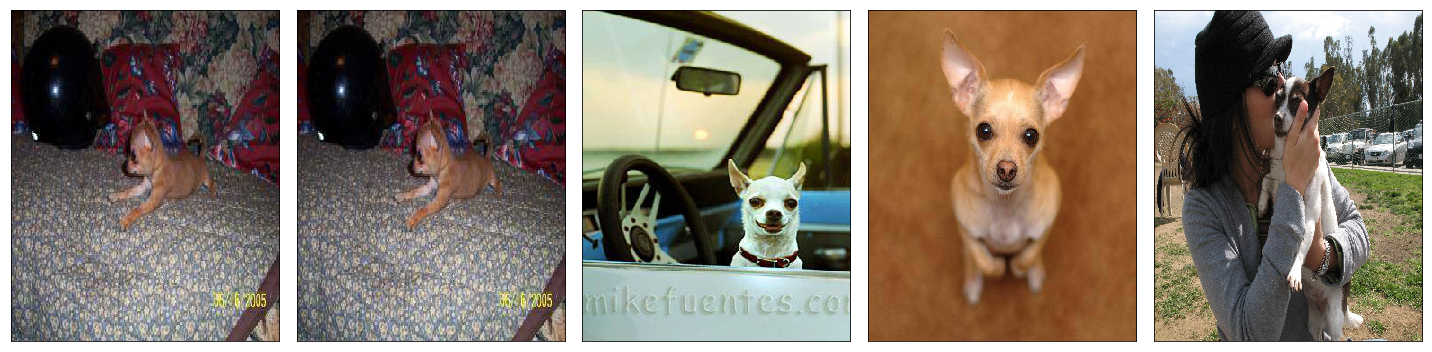

In [9]:
plot_img_df(directory=training_dir, df=train_df, filename="id", label = "label", count=5, num_cat=5)

## 4.2 Countplot for Images of Categories

In [10]:
train_df2 = train_df.copy()
train_df2["label"] = train_df["label"].apply(lambda x: re.sub("_", " ", x))
train_df2["label"] = train_df2["label"].apply(lambda x: x.title())

classes2 = train_df2["label"].unique()
classes2.sort()

rows = (len(classes) - 1)/4

### 4.2.1 Countplot Sorted by Value Count of Categories

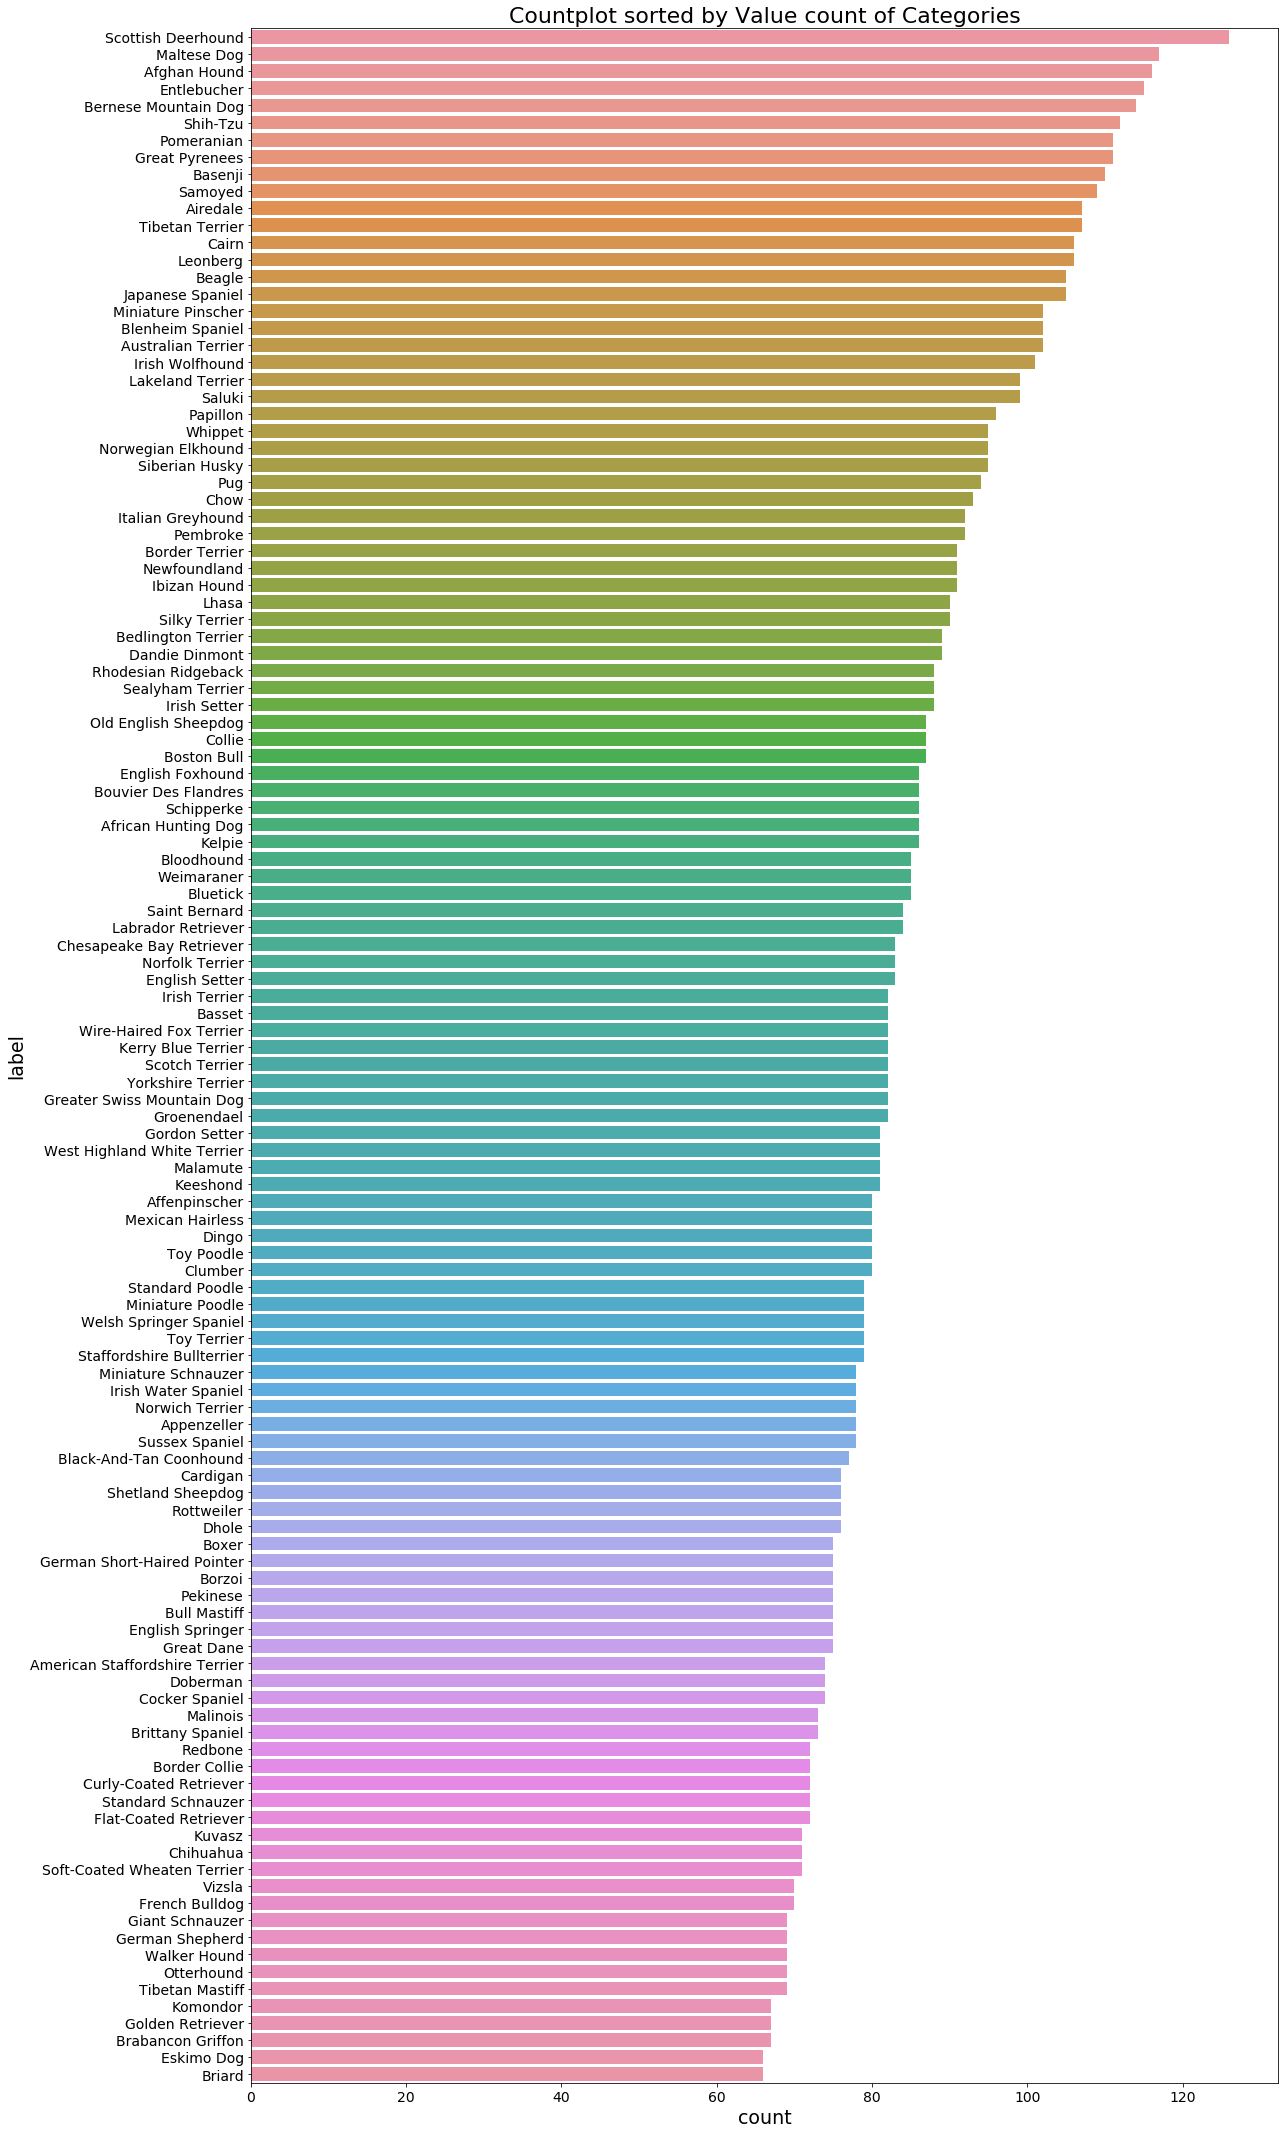

In [11]:
plt.figure(figsize=(18, rows))
ax = sns.countplot(y="label", data=train_df2, order=train_df2["label"].value_counts().index)
plt.title("Countplot sorted by Value count of Categories")
plt.tight_layout()
plt.show() 

### 4.2.2 Countplot Sorted by Alphebetical Order of Category Names

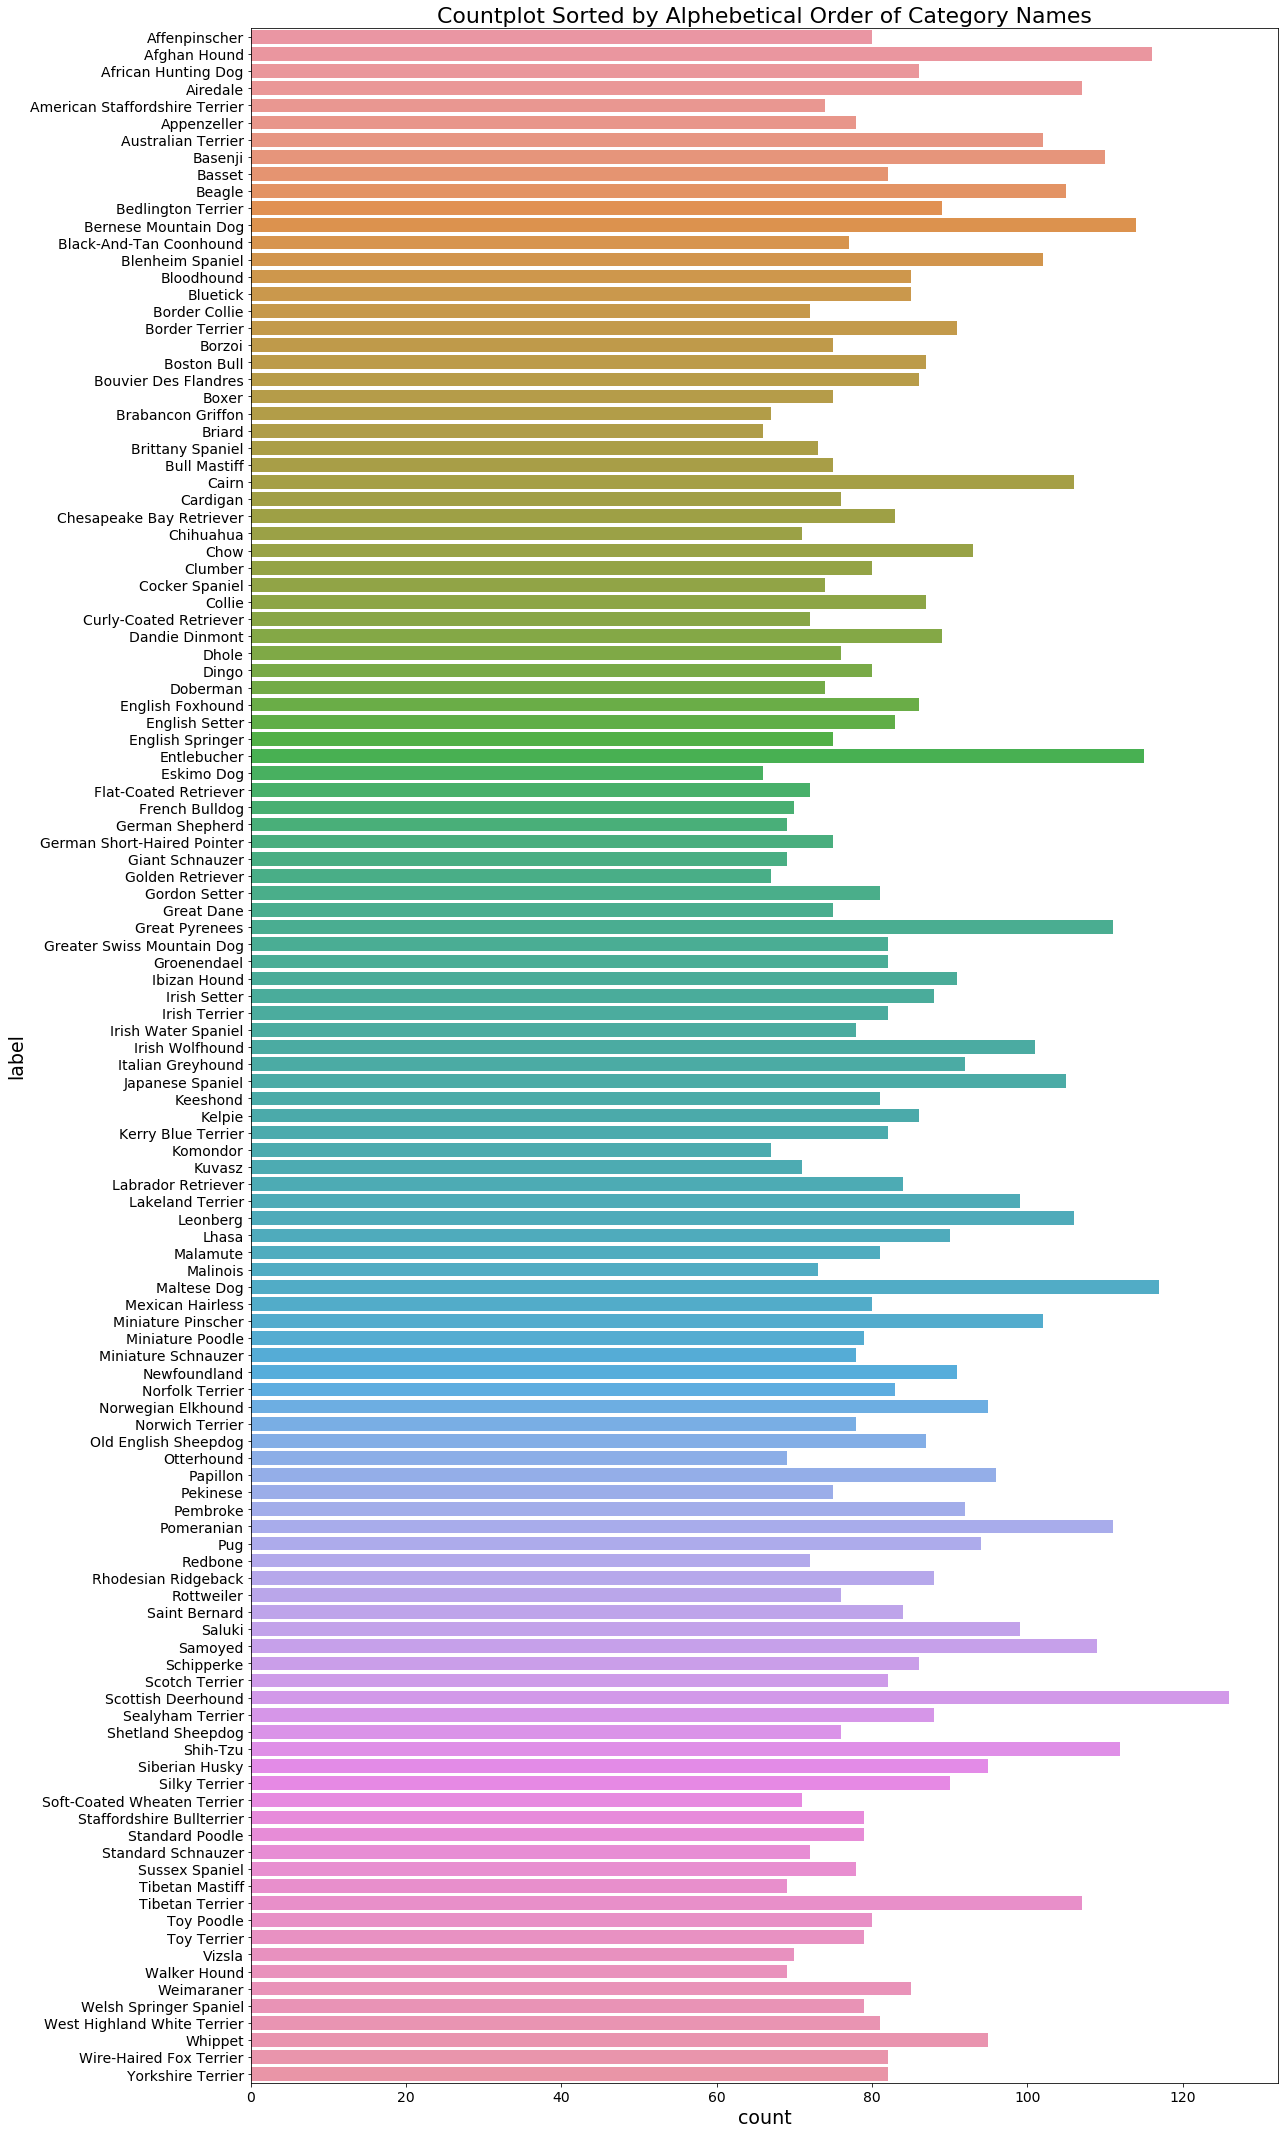

In [12]:
plt.figure(figsize=(18, rows))
ax = sns.countplot(y="label", data=train_df2, order=classes2)
plt.title("Countplot Sorted by Alphebetical Order of Category Names")
plt.tight_layout()
plt.show() 

# 5. Preprocessing Function

During Preprocessing, all of the image has been transformed to target size (299, 299) and pixel value has been rescaled to unit value. (299, 299) is the input shape for Pretrained model "InceptionV3". The target class is treated as categorical and both training and validation image set has been re-shuffled. Some of the images has been horizontally and vertically flipped randomly and sheerness and rotation has been changed to introduce heterogeneity. A part of training dataset has been used as validation set. 

In [13]:
def get_data(batch_size=32, target_size=(299, 299), class_mode="categorical", training_dir=training_dir, testing_dir=testing_dir, x_col="id", y_col="label"):
    print("Preprocessing and Generating Data Batches.......\n")
    
    rescale = 1.0/255

    train_batch_size = batch_size
    validation_batch_size = batch_size*5
    test_batch_size = batch_size*5
    
    train_shuffle = True
    val_shuffle = True
    test_shuffle = False
    
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
#         vertical_flip=True,
        rotation_range=45,
        shear_range=15,
        rescale=rescale,
        validation_split=0.25)

    train_generator = train_datagen.flow_from_dataframe(
        train_df, 
        training_dir,
        x_col=x_col,
        y_col=y_col,  
        target_size=target_size, 
#         classes=classes,
        class_mode=class_mode, 
        batch_size=batch_size, 
        shuffle=True, 
        seed=42,
        subset='training')
    
    
    validation_generator = train_datagen.flow_from_dataframe(
        train_df, 
        training_dir,
        x_col=x_col,
        y_col=y_col,  
#         classes=classes,
        target_size=target_size, 
        class_mode=class_mode, 
        batch_size=validation_batch_size, 
        shuffle=True, 
        seed=42,
        subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=rescale)
    
    test_generator = test_datagen.flow_from_dataframe(
        test_df, 
        testing_dir,
        x_col=x_col,
        y_col=y_col,  
#         classes=classes,
        target_size=target_size, 
        class_mode=class_mode, 
        batch_size=test_batch_size, 
        shuffle=False, 
        seed=42)
    
#     y = [val for sublist in train_generator.classes for val in sublist]
    class_weights = get_weight(train_generator.classes, binary=False)
    
    steps_per_epoch = len(train_generator)
    validation_steps = len(validation_generator)
    
    print("\nPreprocessing and Data Batch Generation Completed.\n")
    
    
    return train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps

# Calculate Class Weights
def get_weight(y, binary=True, n_samples=-1):
    if binary==False:
        class_weights =  cw.compute_class_weight('balanced', np.unique(y), y)
    else:
        d = {x:y.count(x) for x in set(y)}
        num_class_temp = 2
        class_weights = {}

        for cls in d:
            count = d.get(cls)
            class_weight = n_samples / (num_class_temp * count)
            class_weights[cls] = class_weight
#             temp = np.concatenate((np.repeat(0, n_samples-count), np.repeat(1, count)))
#             class_weight =  cw.compute_class_weight('balanced', np.unique(temp), temp)
#             class_weights[cls] = class_weight
    return class_weights


# 6. Model Function

## 6.1 Pretrained Model

In [14]:
def get_model(model_name, input_shape=(96, 96, 3), num_class=2, weights='imagenet', dense_units=1024):
    inputs = Input(input_shape)
    
    if model_name == "Xception":
        base_model = Xception(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNet50":
        base_model = ResNet50(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNet101":
        base_model = keras.applications.resnet.ResNet101(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNet152":
        base_model = keras.applications.resnet.ResNet152(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNet50V2":
        base_model = resnet_v2.ResNet50V2(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNet101V2":
        base_model = resnet_v2.ResNet101V2(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNet152V2":
        base_model = resnet_v2.ResNet152V2(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNeXt50":
        base_model = resnext.ResNeXt50(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNeXt101":
        base_model = resnext.ResNeXt101(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "InceptionV3":
        base_model = InceptionV3(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "InceptionResNetV2":
        base_model = InceptionResNetV2(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "DenseNet201":
        base_model = DenseNet201(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "NASNetMobile":
        base_model = NASNetMobile(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "NASNetLarge":
        base_model = NASNetLarge(include_top=False, weights=weights, input_shape=input_shape)
        

    x = base_model(inputs)
    x = Dropout(0.8)(x) 
    x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.5)(x) 
    x = BatchNormalization()(x)
    x = Dropout(0.8)(x)     

    
    if num_class>1:
        outputs = Dense(num_class, activation="softmax")(x)
    else:
        outputs = Dense(1, activation="sigmoid")(x)

#     model = Model(inputs=base_model.input, outputs=outputs)
    model = Model(inputs=inputs, outputs=outputs)

    model.summary()
    
    
    return model

## 6.2 Model Build from Scratch

In [15]:
def get_conv_model(num_class=2, input_shape=(150,150, 3)):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D())
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D())
    model.add(Dropout(0.2))

    model.add(GlobalAveragePooling2D())
    
    if num_class>1:
        model.add(Dense(num_class, activation='softmax'))
    else:
        model.add(Dense(num_class, activation='sigmoid'))
    
#     print(model.summary())

    return model

# 7. Output Configuration

In [16]:
main_model_dir = output_directory + r"models/"
main_log_dir = output_directory + r"logs/"

try:
    os.mkdir(main_model_dir)
except:
    print("Could not create main model directory")
    
try:
    os.mkdir(main_log_dir)
except:
    print("Could not create main log directory")



model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')


try:
    os.mkdir(model_dir)
except:
    print("Could not create model directory")
    
try:
    os.mkdir(log_dir)
except:
    print("Could not create log directory")
    
model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

# 8. Call Back Configuration

In [17]:
print("Settting Callbacks")

def step_decay(epoch, lr):
    # initial_lrate = 1.0 # no longer needed
    lrate = lr
    if epoch==2:
        lrate = 0.0001  
#     lrate = lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=0.0000001,
    verbose=1)


learning_rate_scheduler = LearningRateScheduler(step_decay, verbose=1)
# f1_metrics = Metrics()



callbacks = [reduce_lr, early_stopping]
# callbacks = [checkpoint, reduce_lr, early_stopping]
# callbacks = [reduce_lr, early_stopping, f1_metrics]


print("Set Callbacks at ", date_time(1))

Settting Callbacks
Set Callbacks at  Timestamp: 2019-09-16 19:23:44


# 9. Load Model

## 9.1 Model Configuration

In [18]:
# dim = 96
# dim = 224
dim = 299

input_shape = (dim, dim, 3)

num_class = len(classes)

weights = 'imagenet'
dense_units = 256

## 9.2 Load Model with Configuration

In [19]:
print("Getting Base Model", date_time(1))

model = get_model(model_name="InceptionV3", input_shape=input_shape, num_class=num_class, weights=weights, dense_units=dense_units)
# model = get_conv_model(num_class=num_class, input_shape=input_shape)
print("Loaded Base Model", date_time(1))

Getting Base Model Timestamp: 2019-09-16 19:23:44
87916544/87910968 [==============================] - 4s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 2048)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
___________________________

# 10. Get Data

## 10.1 Data Configuration

In [20]:
batch_size = 64

class_mode = "categorical"
# class_mode = "binary"

target_size = (dim, dim)
y_col = "label"

## 10.2 Get Data

In [21]:
train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps = get_data(batch_size=batch_size,
                                                                                                                   target_size=target_size,
                                                                                                                   class_mode=class_mode,
                                                                                                                   y_col=y_col)    

Preprocessing and Generating Data Batches.......

Found 7667 validated image filenames belonging to 120 classes.
Found 2555 validated image filenames belonging to 120 classes.
Found 10357 validated image filenames belonging to 1 classes.

Preprocessing and Data Batch Generation Completed.



/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


# 11. Model Compilation

In [22]:
print("Compliling Model ...")


learning_rate = 0.0001
optimizer = Adam(learning_rate)
# optimizer = Adam()


loss = 'categorical_crossentropy'
# loss = 'binary_crossentropy'
metrics = ['accuracy']
# metrics = [auroc]


model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

print("Completed Model Compilation.\n")

Compliling Model ...
Completed Model Compilation.



# 12. Training Model

Trained model on full tranning dataset for 50 epochs and validated on full validation dataset. Adjusted class weight has been used for trainning. For optimization used Adam optimizer with learning rate of 0.0001. For loss calculation used "Categorical Crossentropy" and for model performance evaluation used "Accuracy" as metrics.  

## 12.1 Training Configuration

In [23]:
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

verbose = 1
epochs = 30

In [24]:
# batch_size = 32
# train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps = get_data(batch_size=batch_size)

In [25]:
print("Starting Trainning ...\n")

start_time = time.time()
print(date_time(1))


print("Trainning Model ...\n")


history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=verbose,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    class_weight=class_weights)



elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))


print("\nElapsed Time: " + elapsed_time)
print("Completed Model Trainning", date_time(1))

Starting Trainning ...

Timestamp: 2019-09-16 19:24:21
Trainning Model ...

Epoch 1/30
120/120 [==============================] - 284s 2s/step - loss: 6.1111 - acc: 0.0825 - val_loss: 2.9177 - val_acc: 0.4595
Epoch 2/30
120/120 [==============================] - 223s 2s/step - loss: 3.0454 - acc: 0.3654 - val_loss: 1.4563 - val_acc: 0.6211
Epoch 3/30
120/120 [==============================] - 229s 2s/step - loss: 2.1136 - acc: 0.5261 - val_loss: 1.0041 - val_acc: 0.7170
Epoch 4/30
120/120 [==============================] - 230s 2s/step - loss: 1.6277 - acc: 0.6094 - val_loss: 0.9758 - val_acc: 0.7288
Epoch 5/30
120/120 [==============================] - 229s 2s/step - loss: 1.3971 - acc: 0.6553 - val_loss: 0.9901 - val_acc: 0.7213

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 6/30
120/120 [==============================] - 225s 2s/step - loss: 1.0886 - acc: 0.7180 - val_loss: 0.8310 - val_acc: 0.7671
Epoch 7/30
120/120 [=========================

# 13. Model Performance Visualization
Model Performance  Visualization over the Epochs

## 13.1 Model Performance Visualization Function

In [26]:
def plot_performance(history=None, figure_directory=None):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

#     ylim_pad = [0.005, 0.005]
    ylim_pad = [0, 0]


    plt.figure(figsize=(20, 5))

    # Plot training & validation Accuracy values

    y1 = history.history['acc']
    y2 = history.history['val_acc']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]
    
#     min_y = .96
#     max_y = 1


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()


    # Plot training & validation loss values

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]

#     min_y = .1
#     max_y = 0

    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

## 13.2 Visualization

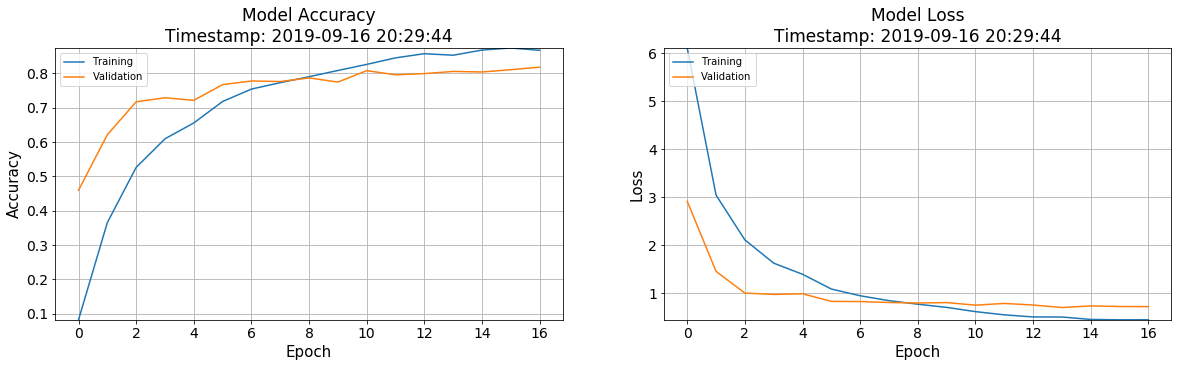

In [27]:
plot_performance(history=history)

# 14. Model Evaluation

In [28]:
model.evaluate_generator(generator=validation_generator, steps=len(validation_generator), verbose=1)

8/8 [==============================] - 56s 7s/step


[0.7682813893558927, 0.7882583260302908]

# 15. Prediction and Inference

In [29]:
label_map = (train_generator.class_indices)
label_map_inv = {v: k for k, v in label_map.items()}

In [30]:
ypreds = model.predict_generator(generator=test_generator, steps = len(test_generator),  verbose=1)

33/33 [==============================] - 79s 2s/step


In [31]:
# ypreds

In [32]:
ypred = ypreds.argmax(axis=-1)
# ypred

# 16. Inference Performance Visualization

In [33]:
def get_rand_test_img(test_generator=None, labels_test=None, count=5):

    filepaths = test_generator.filepaths
    file_names = test_generator.filenames

    selected_filepaths = []
    selected_file_names = []
    selected_labels = []

    mem = set()

    i = count

    num_test_sample = test_generator.n

    for file in test_generator.labels:
        if i<=0:
            break

        rnd = random.randint(0, test_generator.n)
        while rnd in mem:
            rnd = random.randint(0, test_generator.n)

        selected_filepaths.append(filepaths[rnd])
        selected_file_names.append(file_names[rnd])
        
        lbl = label_map_inv[labels_test[rnd]]
        lbl = re.sub("_", " ", lbl)
        lbl = lbl.title()

        selected_labels.append(lbl)
        
        i-=1
    
    return selected_file_names, selected_file_names, selected_labels

In [34]:
test_img_count = 10
labels_test = ypred
selected_file_names, selected_file_names, selected_labels = get_rand_test_img(test_generator=test_generator, labels_test=labels_test, count=test_img_count)

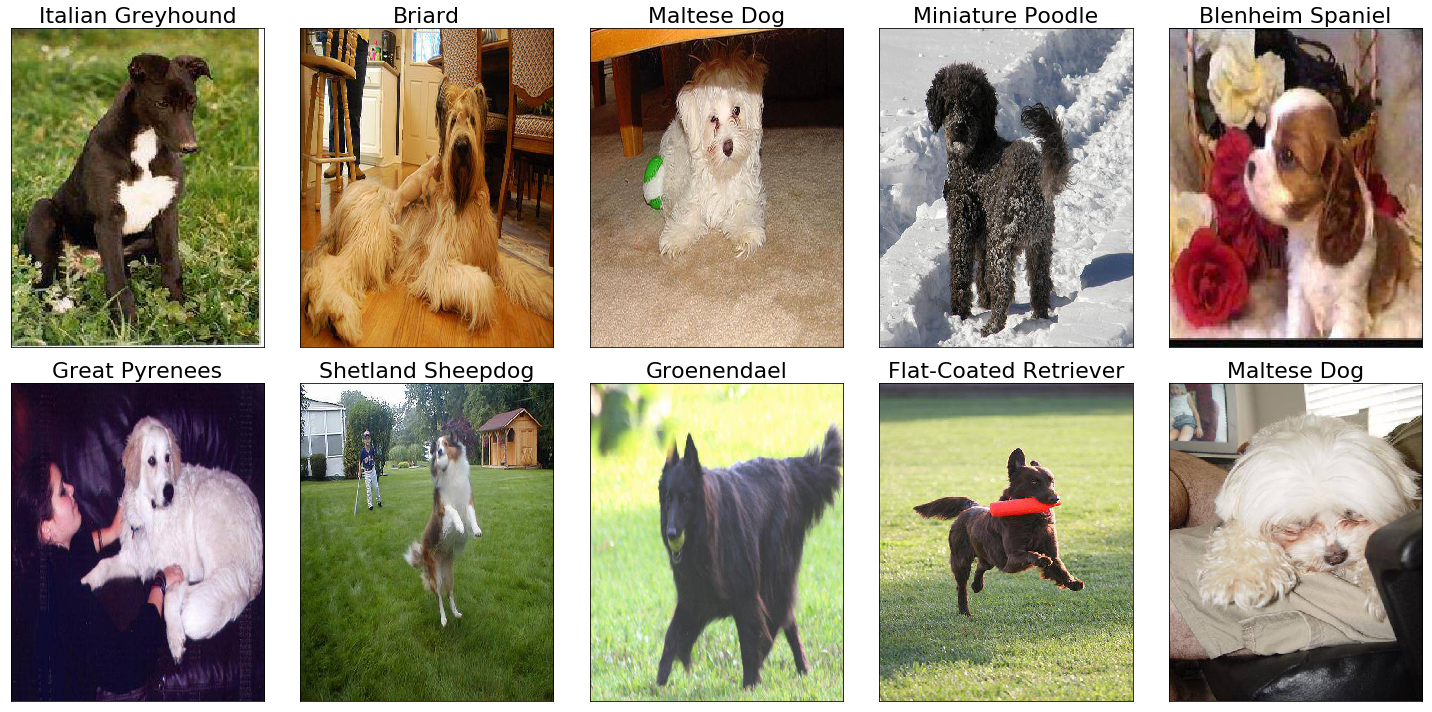

In [35]:
count = test_img_count

ncols = 5
nrows = count//ncols if count%ncols==0 else count//ncols+1

figsize=(20, ncols*nrows)

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5


params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)


i = 0

for i in range(0, count):
    if i>test_img_count:
        break    
    plt.subplot(nrows, 5, i+1)
    plot_image(selected_file_names[i], testing_dir, aspect='auto')
    plt.title(selected_labels[i])

plt.tight_layout()
plt.show()     

In [36]:
# count = 5

# ncols = 5
# nrows = count//ncols if count%ncols==0 else count//ncols+1

# figsize=(20, ncols*nrows)

# ticksize = 14
# titlesize = ticksize + 8
# labelsize = ticksize + 5


# params = {'figure.figsize' : figsize,
#           'axes.labelsize' : labelsize,
#           'axes.titlesize' : titlesize,
#           'xtick.labelsize': ticksize,
#           'ytick.labelsize': ticksize}

# plt.rcParams.update(params)


# for label in set(test_generator.classes):
#     print(label_map_inv[label])
#     x = np.where(ypred == 1)[0].tolist()
#     s = np.random.choice(x, count)
#     j=0
#     for index in s:
#         file = test_generator.filenames[index]
#         print(file)
#         plt.subplot(nrows, 5, j+1)
#         plot_image(file, testing_dir, aspect='auto')
#         j=j+1

#     plt.tight_layout()
#     plt.show()
        

# 17. Submission 

In [37]:
sample_submission = pd.read_csv(input_directory+"sample_submission.csv")
sample_submission.head()

id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e       0.008333      0.008333   
1  00102ee9d8eb90812350685311fe5890       0.008333      0.008333   
2  0012a730dfa437f5f3613fb75efcd4ce       0.008333      0.008333   
3  001510bc8570bbeee98c8d80c8a95ec1       0.008333      0.008333   
4  001a5f3114548acdefa3d4da05474c2e       0.008333      0.008333   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0             0.008333  0.008333                        0.008333     0.008333   
1             0.008333  0.008333                        0.008333     0.008333   
2             0.008333  0.008333                        0.008333     0.008333   
3             0.008333  0.008333                        0.008333     0.008333   
4             0.008333  0.008333                        0.008333     0.008333   

   australian_terrier   basenji    basset  ...  toy_poodle  toy_terrier  \
0            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
1            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
2            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
3            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
4            0.008333  0.008333  0.008333  ...    0.008333     0.008333   

     vizsla  walker_hound  weimaraner  welsh_springer_spaniel  \
0  0.008333      0.008333    0.008333                0.008333   
1  0.008333      0.008333    0.008333                0.008333   
2  0.008333      0.008333    0.008333                0.008333   
3  0.008333      0.008333    0.008333                0.008333   
4  0.008333      0.008333    0.008333                0.008333   

   west_highland_white_terrier   whippet  wire-haired_fox_terrier  \
0                     0.008333  0.008333                 0.008333   
1                     0.008333  0.008333                 0.008333   
2                     0.008333  0.008333                 0.008333   
3                     0.008333  0.008333                 0.008333   
4                     0.008333  0.008333                 0.008333   

   yorkshire_terrier  
0           0.008333  
1           0.008333  
2           0.008333  
3           0.008333  
4           0.008333  

[5 rows x 121 columns]

In [38]:
test_dir_files = os.listdir(testing_dir)
test_gen_files = test_generator.filenames
sample_submission_files = sample_submission["id"]
len(test_dir_files), len(test_gen_files), len(sample_submission_files)

(10358, 10357, 10357)

In [39]:
m = {}
l = len(test_gen_files)
for i in range(l):
    m[test_gen_files[i]] = ypreds[i] 

In [40]:
labels = (train_generator.class_indices)
labels = list(labels.keys())

In [41]:
ypreds_sync = []
for f in sample_submission_files:
    ypreds_sync.append(m[f+".jpg"]) 

In [42]:
test_df = pd.DataFrame(data=ypreds_sync, columns=labels)
test_df.head()

affenpinscher  afghan_hound  african_hunting_dog      airedale  \
0   3.441604e-14  3.324760e-14         7.837687e-17  5.515424e-18   
1   1.405467e-12  2.067560e-13         1.609438e-12  1.181170e-12   
2   1.844587e-09  2.219066e-06         4.086071e-08  1.035589e-07   
3   5.682511e-04  3.834736e-04         1.051023e-05  4.744482e-05   
4   5.689332e-01  8.557714e-05         8.791743e-06  1.416048e-06   

   american_staffordshire_terrier   appenzeller  australian_terrier  \
0                    1.812208e-17  3.613147e-17        6.845229e-18   
1                    2.821355e-13  1.085669e-12        4.368454e-11   
2                    8.074608e-09  2.687317e-08        7.010395e-08   
3                    8.489705e-05  1.640255e-04        2.587738e-06   
4                    4.620542e-06  2.801307e-05        3.181894e-04   

        basenji        basset        beagle  ...    toy_poodle   toy_terrier  \
0  7.531045e-18  1.649852e-17  1.429898e-18  ...  2.106517e-17  1.131951e-16   
1  1.645946e-12  1.001766e-12  1.118171e-12  ...  2.638667e-11  1.885680e-12   
2  1.226162e-08  2.033630e-08  3.105994e-08  ...  4.047186e-09  5.394777e-08   
3  2.161639e-05  5.304123e-06  9.531100e-06  ...  1.572915e-05  3.471781e-06   
4  4.595656e-06  2.761930e-05  5.026013e-06  ...  1.786153e-04  1.767881e-05   

         vizsla  walker_hound    weimaraner  welsh_springer_spaniel  \
0  4.135957e-17  7.214601e-18  3.205187e-18            1.016255e-16   
1  2.418806e-11  3.586203e-11  5.313321e-12            8.058675e-13   
2  7.335290e-09  2.368123e-08  9.796928e-08            9.385756e-07   
3  9.989769e-05  3.763677e-06  1.019332e-05            2.605172e-05   
4  4.780560e-05  2.381066e-06  2.014899e-05            2.338219e-05   

   west_highland_white_terrier       whippet  wire-haired_fox_terrier  \
0                 4.433855e-15  1.458624e-18             1.089434e-16   
1                 1.249645e-09  1.476567e-13             2.650094e-13   
2                 6.287659e-09  1.274294e-08             1.066414e-08   
3                 2.797587e-05  6.116409e-07             1.228254e-07   
4                 1.727502e-05  1.073174e-05             3.077420e-05   

   yorkshire_terrier  
0       7.758263e-17  
1       3.553193e-12  
2       3.401288e-08  
3       9.781049e-06  
4       5.433768e-04  

[5 rows x 120 columns]

In [43]:
test_df["id"]  = sample_submission_files

cols = test_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
test_df = test_df[cols]

test_df.to_csv('submission.csv', index=False)
test_df.head()

id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e   3.441604e-14  3.324760e-14   
1  00102ee9d8eb90812350685311fe5890   1.405467e-12  2.067560e-13   
2  0012a730dfa437f5f3613fb75efcd4ce   1.844587e-09  2.219066e-06   
3  001510bc8570bbeee98c8d80c8a95ec1   5.682511e-04  3.834736e-04   
4  001a5f3114548acdefa3d4da05474c2e   5.689332e-01  8.557714e-05   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         7.837687e-17  5.515424e-18                    1.812208e-17   
1         1.609438e-12  1.181170e-12                    2.821355e-13   
2         4.086071e-08  1.035589e-07                    8.074608e-09   
3         1.051023e-05  4.744482e-05                    8.489705e-05   
4         8.791743e-06  1.416048e-06                    4.620542e-06   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  3.613147e-17        6.845229e-18  7.531045e-18  1.649852e-17  ...   
1  1.085669e-12        4.368454e-11  1.645946e-12  1.001766e-12  ...   
2  2.687317e-08        7.010395e-08  1.226162e-08  2.033630e-08  ...   
3  1.640255e-04        2.587738e-06  2.161639e-05  5.304123e-06  ...   
4  2.801307e-05        3.181894e-04  4.595656e-06  2.761930e-05  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  2.106517e-17  1.131951e-16  4.135957e-17  7.214601e-18  3.205187e-18   
1  2.638667e-11  1.885680e-12  2.418806e-11  3.586203e-11  5.313321e-12   
2  4.047186e-09  5.394777e-08  7.335290e-09  2.368123e-08  9.796928e-08   
3  1.572915e-05  3.471781e-06  9.989769e-05  3.763677e-06  1.019332e-05   
4  1.786153e-04  1.767881e-05  4.780560e-05  2.381066e-06  2.014899e-05   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            1.016255e-16                 4.433855e-15  1.458624e-18   
1            8.058675e-13                 1.249645e-09  1.476567e-13   
2            9.385756e-07                 6.287659e-09  1.274294e-08   
3            2.605172e-05                 2.797587e-05  6.116409e-07   
4            2.338219e-05                 1.727502e-05  1.073174e-05   

   wire-haired_fox_terrier  yorkshire_terrier  
0             1.089434e-16       7.758263e-17  
1             2.650094e-13       3.553193e-12  
2             1.066414e-08       3.401288e-08  
3             1.228254e-07       9.781049e-06  
4             3.077420e-05       5.433768e-04  

[5 rows x 121 columns]